In [82]:
import requests
from bs4 import BeautifulSoup

from selenium.webdriver.common.action_chains import ActionChains
from time import sleep
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
import json
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import re
from pprint import pprint
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
class VanguardInsights:
    
    def __init__(self, all_insight_link):
        self.all_insight_link = all_insight_link
        service = Service(executable_path=ChromeDriverManager().install())
        self.driver = webdriver.Chrome(service=service)
            
    @staticmethod
    def extract_content_with_id(link):
        response = requests.get(link)
        soup = BeautifulSoup(response.text)
        content = ' '.join([i.text for i in soup.find_all("div", {"id": "iw_placeholder1585759247342"})]).strip()
        return content
            
    def get_article_insight(self):
        
        self.driver.get(self.all_insight_link)
        sleep(10)

        all_pages = []

        for i in range(18):

            title_tags = self.driver.find_elements(By.XPATH,'//*[(@id = "insights-archive-section")]//h3')
            title_contents = self.driver.find_elements(By.XPATH, '//*[(@id = "insights-archive-section")]//*[contains(concat( " ", @class, " " ), concat( " ", "p2", " " ))]')
            date_perspectives = self.driver.find_elements(By.XPATH,'//*[contains(concat( " ", @class, " " ), concat( " ", "eyebrow", " " ))]')
            perspectives = self.driver.find_elements(By.XPATH, '//*[contains(concat( " ", @class, " " ), concat( " ", "type", " " ))]')
            # dates = browser.find_elements(By.CSS_SELECTOR, '.content-eyebrow .eyebrow')
            tags = self.driver.find_elements(By.CSS_SELECTOR, "[id='insights-archive'] [class='tags']")
            tags = [i.find_elements(By.CSS_SELECTOR, "[id='insights-archive'] [class='tags'] [class='pill tag']") for i in tags]
            links = self.driver.find_elements(By.CSS_SELECTOR, '.detail-link')



            title_tag = [i.text for i in title_tags] 
            title_content = [i.text for i in title_contents]
            date_perspective = [i.text for i in date_perspectives]
            date = [''.join(re.findall(r'[A-Z]+\s\d+,\s\d+', i)) for i in date_perspective[1:]]
            perspective = [i.text for i in perspectives]
            #date = [i.text for i in dates]
            tag = [[j.text for j in i]for i in tags]
            links_list = [link.get_attribute('href') for link in links]

            list_of_dict = []
            for tg,tc,d,p,t,l in zip(title_tag, title_content, date, perspective, tag, links_list):
                economy_market_dict = {
                                    'company': 'Vanguard', 
                                    'topic': 'Insight', 
                                    'articel_title': tg, 
                                    'abstract' : tc,
                                    'date' : d,
                                    'perspective' : p,
                                    'tag': ','.join(t),
                                    'link':l,
                                    'content':self.extract_content_with_id(l),
                }
                list_of_dict.append(economy_market_dict)


            all_pages.append(list_of_dict)
            next_page = self.driver.find_element(By.CSS_SELECTOR,'#insights-archive-section > div.pagination > div.pagination__arrows > span.icon.icon-right')
            next_page.click()

        self.driver.quit()
        vanguard_insight_list = []
        for p_8 in all_pages:
            for p in p_8:
                vanguard_insight_list.append(p)
                
        return vanguard_insight_list


In [42]:
vanguard_insight_obj = VanguardInsights('https://advisors.vanguard.com/insights/all')
vanguard_insight_list = vanguard_insight_obj.get_article_insight()

In [83]:
df = pd.DataFrame(vanguard_insight_list)

In [90]:
d = {'U.S.': 0,
    'Fixed Income': 0,
    'International':0,
    'ESG Strategies':0,
    "Advisor's Alpha®":0,
    'Portfolio Construction': 0,
    'ETF Investing': 0,
    'Equities': 0,
    'Behavioral Coaching':0,
    'Wealth Management': 0,
    'Alternatives': 0,
    'Factor-based Strategies': 0,
    'Bear Markets': 0
    }

for i in df['tag']:
    if 'U.S.' in i:
        d['U.S.'] += 1
    if 'Fixed Income' in i:
        d['Fixed Income'] += 1
    if 'International' in i:
        d['International'] += 1
    if 'ESG Strategies' in i:
        d['ESG Strategies'] += 1
    if "Advisor's Alpha®" in i :
        d["Advisor's Alpha®"] += 1
    if 'Portfolio Construction' in i:
        d['Portfolio Construction'] += 1
    if 'ETF Investing' in i:
        d['ETF Investing'] += 1
    if 'Equities' in i:
        d['Equities'] += 1
    if 'Behavioral Coaching' in i:
        d['Behavioral Coaching'] +=1
    if 'Wealth Management' in i:
        d['Wealth Management'] += 1
    if 'Alternatives' in i:
        d['Alternatives'] +=1
    if 'Factor-based Strategies' in i:
        d['Factor-based Strategies'] +=1
    if 'Bear Markets' in i:
        d['Bear Markets'] +=1

In [91]:
df_barplot = pd.DataFrame([d]).T
df_barplot.rename(columns={0:"count"}, inplace=True)
df_barplot = df_barplot.sort_values('count', ascending=False)

In [92]:
d.keys()

dict_keys(['U.S.', 'Fixed Income', 'International', 'ESG Strategies', "Advisor's Alpha®", 'Portfolio Construction', 'ETF Investing', 'Equities', 'Behavioral Coaching', 'Wealth Management', 'Alternatives', 'Factor-based Strategies', 'Bear Markets'])

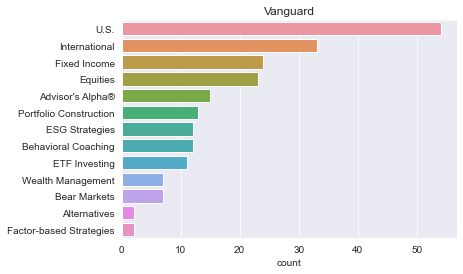

In [93]:
sns.set_style('darkgrid')
sns.barplot(y=df_barplot.index,x=df_barplot['count'])
plt.title('Vanguard')
plt.show()